# Clustering analysis and community detection

## 1.Loading the essentical package

In [1]:
from pandas import Series,DataFrame
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import itertools
import operator
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import networkx as nx
import networkx.algorithms.community as nxcom
from node2vec import Node2Vec
import operator 

D:\anaconda2020\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 2. clustring analysis
###  2.1 Import the dataset and obtain the preprocessed data
#### 2.1.1 Get dataset fro a certain year
Data for 2020 is obtained firstly as example

In [2]:
df = pd.read_excel('../data/all_submission_files.xlsx')
data = df[df["report_end_date"].dt.year == 2020]
data.head(n=6)

,report_end_date,cik,nameOfIssuer,titleOfClass,cusip,value,sshPrnamt,sshPrnamtType
0,2020-09-30,1129770,SPDR S&P 500,COM,824348106,70889608000,211680,SH
1,2020-09-30,1129770,SPDR Dow Jones Ind,COM,78467x109,29886300000,107698,SH
2,2020-09-30,1129770,Ishares Russell,COM,464287622,26825894000,143339,SH
3,2020-09-30,1129770,Invesco QQQ TRUST,COM,73935a104,21672909000,78005,SH
4,2020-09-30,1129770,iShares Russell 20,COM,464287655,9434973000,62988,SH
5,2020-09-30,1129770,SPDR S&P Mid-Cap 4,COM,78464a821,9351708000,27600,SH


#### 2.1.2 Summary dataset
Get the number of stocks and total amount of each company’s investment in stocks in 2020

In [4]:
data_summary = data.groupby('cik').agg({'value': ['sum', 'count']})
index_name = data_summary.index
total_value = []
number_stocks = []
for i in range(0, len(data_summary)):
  total_value.append(data_summary.values[i, 0])
  number_stocks.append(data_summary.values[i, 1])
data_final = {'cik':index_name,'number_stocks': number_stocks, 'total_value': total_value}
data_final = DataFrame(data_final)
data_final = data_final.drop(data_final[data_final['total_value']==0].index)
data_final.head(n=6)

,cik,number_stocks,total_value
0,732847,80,248377000
1,750641,623,2192576000
2,819535,86,777300000
3,883790,168,639939000
4,903944,79,2885946000
5,911270,49,941165000


#### 2.1.3 Adjust the data scale
Log the data value of total_value and number_stocks

In [7]:
data_log = data_final.copy()
data_log['number_stocks'] = np.log(data_log['number_stocks'])
data_log['total_value'] = np.log(data_log['total_value'])
data_log.head(n=6)

,cik,number_stocks,total_value
0,732847,4.382027,19.330458
1,750641,6.434547,21.508343
2,819535,4.454347,20.471337
3,883790,5.123964,20.276883
4,903944,4.369448,21.783119
5,911270,3.891820,20.662629


### 2.2 Visualize the data

#### 2.2.1 Plot the dataset (log) 

<Figure size 1080x1080 with 0 Axes>

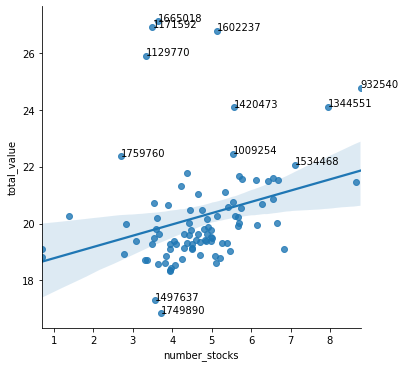

In [11]:
data_label= data_log[(data_log.total_value>22)|(data_log.total_value<18)]
plt.figure(figsize=(15,15))
sns.lmplot(x='number_stocks',y='total_value',data=data_log,fit_reg=True) 
for i in range (len(data_label)):
    plt.annotate(data_label['cik'].iloc[i],(data_label['number_stocks'].iloc[i],data_label['total_value'].iloc[i]))


#### 2.2.2 Get the suitable number of clusters 

Text(0, 0.5, 'WCSS')

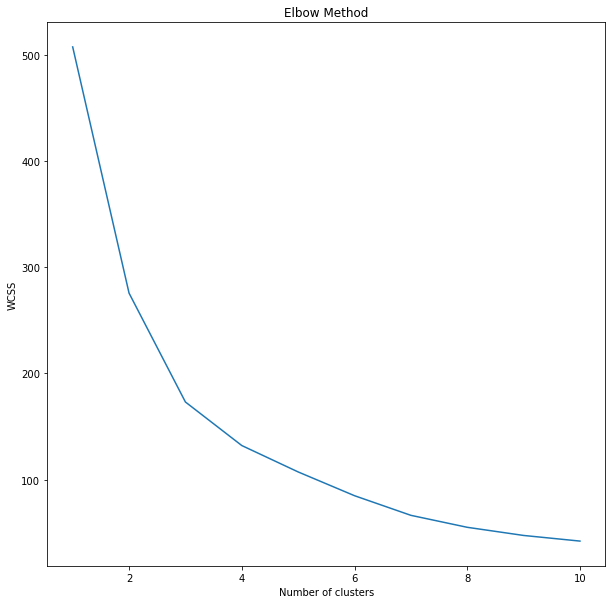

In [12]:
wcss = []
n=11
data_analysis = data_log.drop(columns="cik")
if len(data_analysis)<11:
    n=len(data_analysis)
for i in range(1, n):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data_analysis)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1, n), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

#### 2.2.3 Clustering analysis (4 clusters)

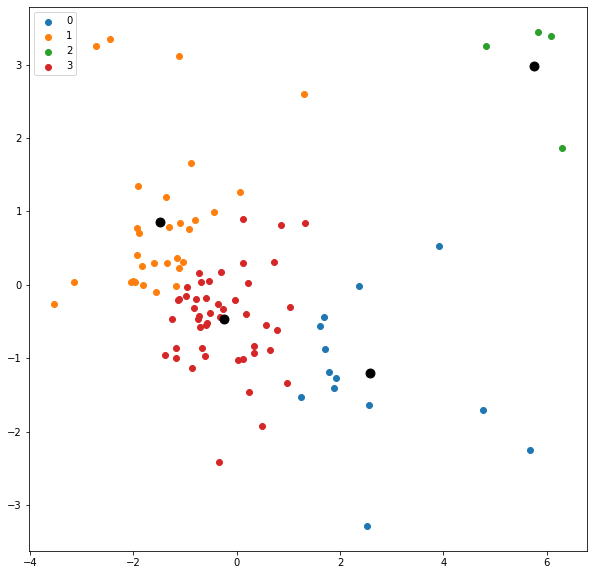

In [14]:
pca = PCA(2)
data_cluster = pca.fit_transform(data_analysis)
kmeans = KMeans(n_clusters=4)
label = kmeans.fit_predict(data_cluster)
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
plt.figure(figsize=(10,10))
for i in u_labels:
    plt.scatter(data_cluster[label == i, 0], data_cluster[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color="black")
plt.legend()

#### 2.2.4 Obtain the cik of different clusters

In [15]:
def get_cik (label_n):
    label_list = pca.inverse_transform(data_cluster[label==label_n])
    cik = []
    for i in range(len(label_list)):
        cik.append(data_log[round(data_log['total_value'],5)==round(label_list[i][1],5)]['cik'].values[0])
    return cik

cik_all=[]
for i in u_labels:
    cik_all.append(get_cik(i))

4

#### 2.2.5 Caculate the deviation rate

In [20]:
num_all_cluster=len(cik_all[0])+len(cik_all[1])++len(cik_all[2])+len(cik_all[3])
num_clust_1_3 = len(cik_all[1])+len(cik_all[0])
num_clust_1_3/num_all_cluster

0.4574468085106383

## 3.Community Detection with networkx
### 3.1 Select top 6 shareholdngs

In [22]:
# for each cik, we just select top 6 shareholdings 
df_top6 = data.sort_values('value',ascending = False).groupby('cik').head(6)

### 3.2 Graph of the data

In [23]:
# Find all the possible CIK combinations (sorted) of length 2
all_cik_pairs = list(itertools.combinations(df_top6['cik'].unique(), 2))

In [24]:
df_top6[df_top6['cik']==all_cik_pairs[0][0]]

,report_end_date,cik,nameOfIssuer,titleOfClass,cusip,value,sshPrnamt,sshPrnamtType
0,2020-09-30,1129770,SPDR S&P 500,COM,824348106,70889608000,211680,SH
1,2020-09-30,1129770,SPDR Dow Jones Ind,COM,78467x109,29886300000,107698,SH
2,2020-09-30,1129770,Ishares Russell,COM,464287622,26825894000,143339,SH
3,2020-09-30,1129770,Invesco QQQ TRUST,COM,73935a104,21672909000,78005,SH
4,2020-09-30,1129770,iShares Russell 20,COM,464287655,9434973000,62988,SH
5,2020-09-30,1129770,SPDR S&P Mid-Cap 4,COM,78464a821,9351708000,27600,SH


In [25]:
# For each CIK pair, find the number of overlapping cusips
# Creates a list [[cik1, cik2], nr_of_overlapping_cusips]
nodes_and_edges = []
for cik_pair in all_cik_pairs:
    df1 = df_top6[df_top6['cik']==cik_pair[0]]
    df2 = df_top6[df_top6['cik']==cik_pair[1]]
    nr_of_shared_cusips = len(df2[df2["cusip"].isin(df1["cusip"])])
    # add weight for each conbination: the weight = log(sum(cik1.value)+sum(cik2.value))
    if nr_of_shared_cusips == 0:
        weight=0
    else:
        weight = round(np.log(df1['value'].sum()+df2['value'].sum()),2)
    nodes_and_edges.append([cik_pair,weight])

In [26]:
#adjust the weigth for better visulation on the plot: (log2(weight)-mean(log2))*10
weigth_list=[(np.log2(n)-4.3)*10 for c,n in nodes_and_edges if n>0]

In [27]:
df_top6[df_top6['cik']==all_cik_pairs[1][0]]

,report_end_date,cik,nameOfIssuer,titleOfClass,cusip,value,sshPrnamt,sshPrnamtType
0,2020-09-30,1129770,SPDR S&P 500,COM,824348106,70889608000,211680,SH
1,2020-09-30,1129770,SPDR Dow Jones Ind,COM,78467x109,29886300000,107698,SH
2,2020-09-30,1129770,Ishares Russell,COM,464287622,26825894000,143339,SH
3,2020-09-30,1129770,Invesco QQQ TRUST,COM,73935a104,21672909000,78005,SH
4,2020-09-30,1129770,iShares Russell 20,COM,464287655,9434973000,62988,SH
5,2020-09-30,1129770,SPDR S&P Mid-Cap 4,COM,78464a821,9351708000,27600,SH


In [28]:
# The number of nodes that are connected
len([c for c,n in nodes_and_edges if n>0])

1352

In [29]:
# Build a network of all CIK's.
G=nx.Graph()
for (cik1, cik2), weight in nodes_and_edges:
    if weight == 0:
        pass
        # Don't add the nodes that are not connected, makes the graph impossible to understand
        # G.add_node(cik1)
        # G.add_node(cik2)
    elif weight > 1:
        G.add_edge(cik1,cik2,weight=nr_of_shared_cusips)

In [30]:
# Find the communities
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
# Count the communities
print(f"The group of investment funds has {len(communities)} communities.")

The group of investment funds has 4 communities.


In [31]:
# Helper functions to plot the graph with community labels
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)


In [32]:
# Set node and edge communities
set_node_community(G, communities)
set_edge_community(G)

node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
edge_color = [get_color(G.edges[v]['community']) for v in G.edges]

community_external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
community_1 = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 1]
community_2 = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 2]
community_3 = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 3]
community_4 = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 4]
community_all=[community_1,community_2,community_3,community_4]

In [33]:
color_set=list(set(edge_color))
community_1_color=color_set[2]
community_2_color=color_set[1]
community_3_color=color_set[3]
community_4_color=color_set[0]
community_color_all = [community_1_color,community_2_color,community_3_color,community_4_color]

In [34]:
#creat the node degree list for weigth node size
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')
node_degree=[np.log(i)*400 for i in degree_dict.values()]

In [35]:
def hist_com_degree(number):
    comm=[]
    for i in G.nodes:
        if G.nodes[i]['community'] ==number:
            comm.append(degree_dict[i])
    return comm

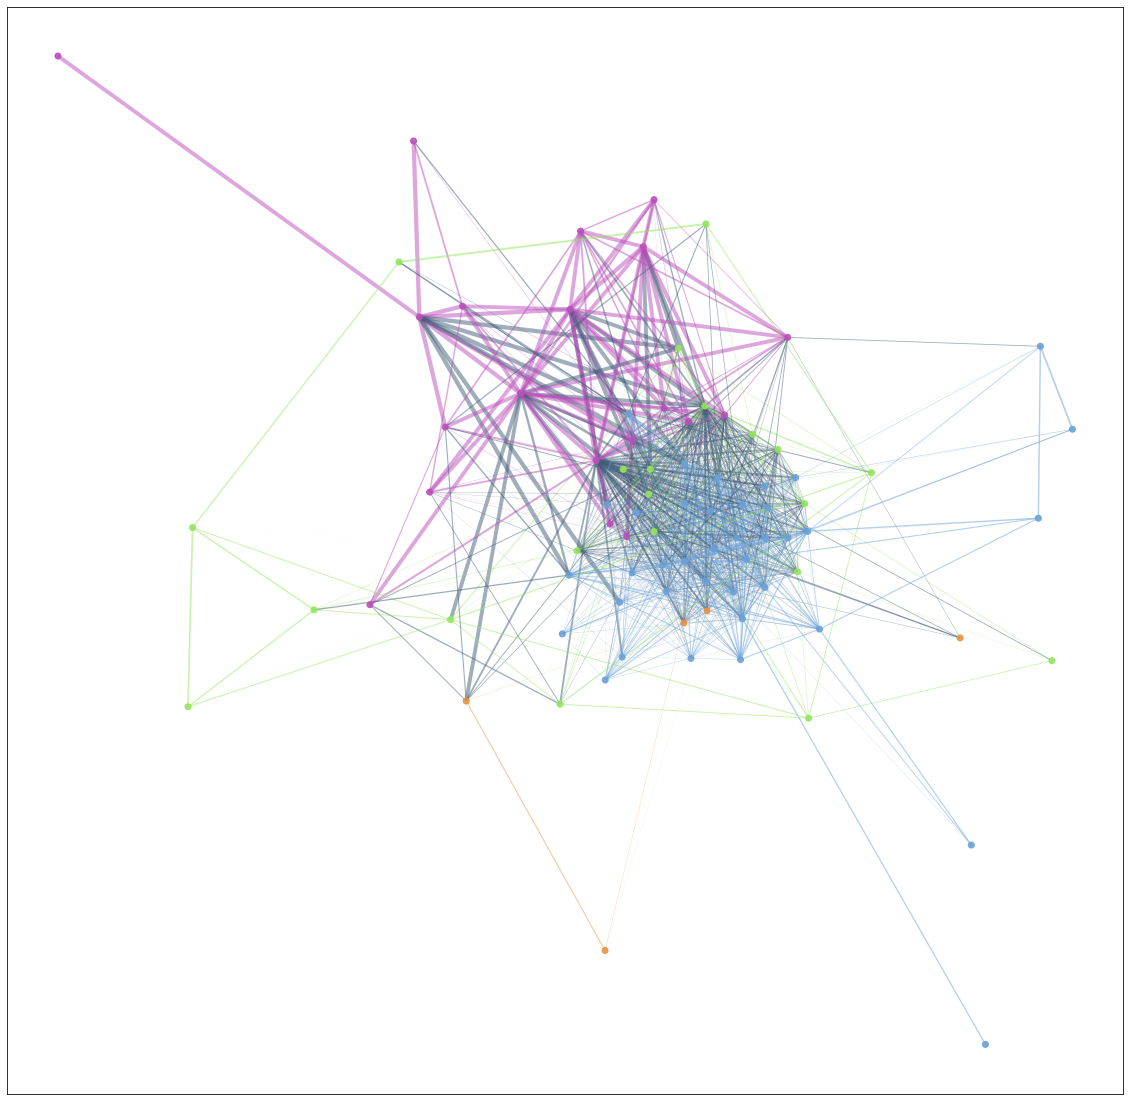

In [67]:
node_size =  None
edge_width = [w for _,w in nodes_and_edges]
pos = nx.spring_layout(G)
plt.figure(figsize=(20,20))
# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.5, width=weigth_list, edge_color=edge_color)
nx.draw_networkx_nodes(G, pos, node_size=None, node_color=node_color, alpha=0.9)
label_options = {"ec": "k", "fc": "white"}
# _ = nx.draw_networkx_labels(G, pos, font_size=14, bbox=label_options)

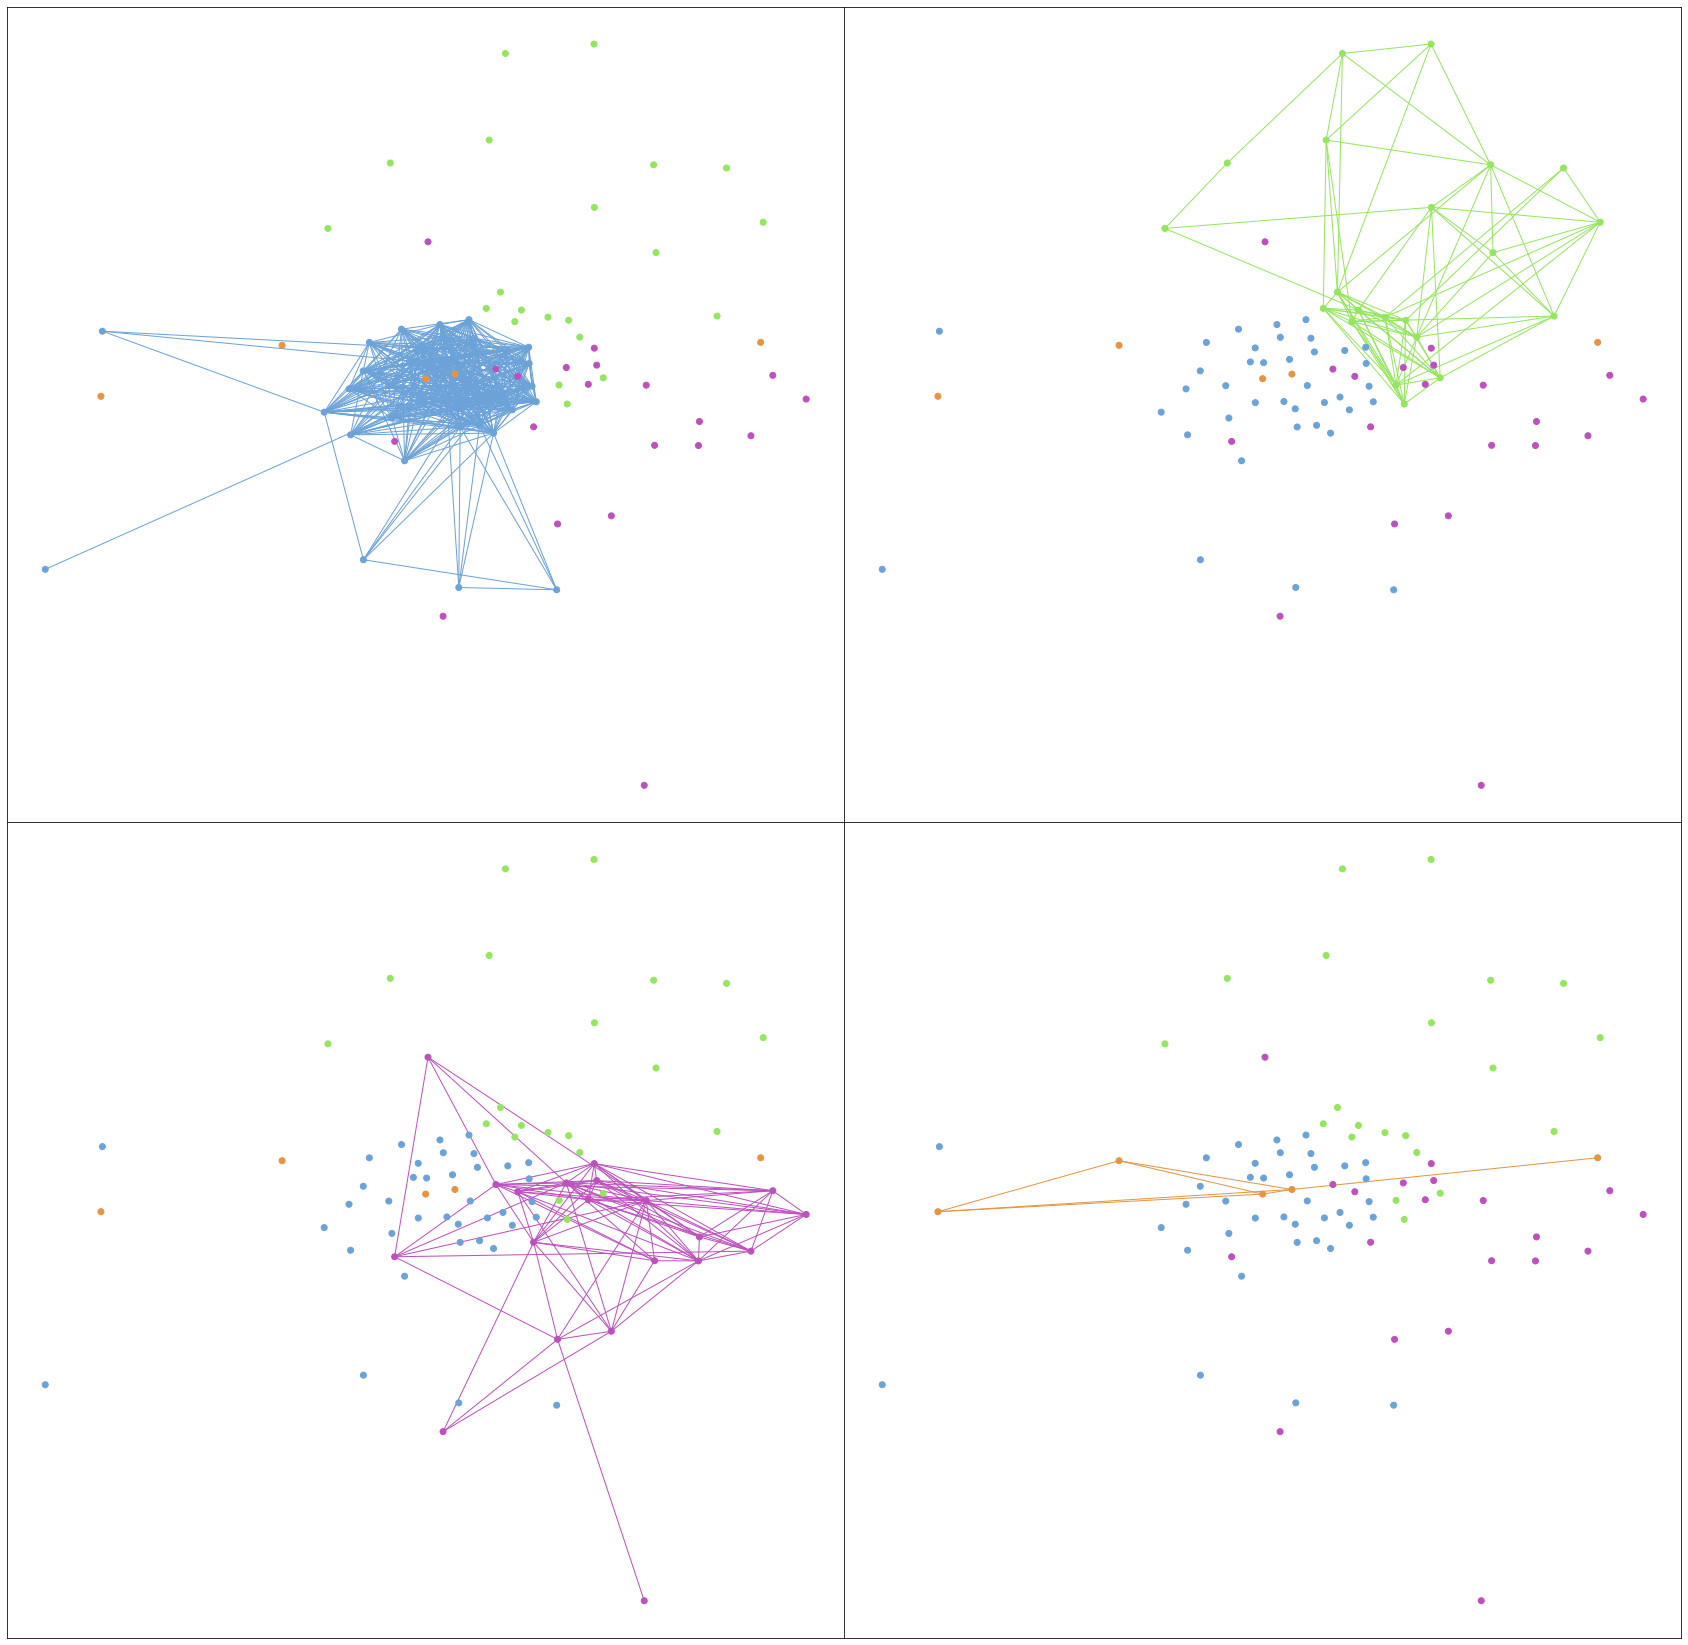

In [61]:
comm_pos_s = nx.spring_layout(G)
comm_pos_k = nx.kamada_kawai_layout(G)


plt.rcParams.update({'figure.figsize': (30, 30)})

fig, ax = plt.subplots(2,2)
plt.subplots_adjust(wspace=0, hspace=0)

nx.draw_networkx(
    G,
    pos=comm_pos_s,
    node_color=node_color,
    node_size=None,
    ax=ax[0,0],
    edgelist=community_all[0],
    edge_color=community_color_all[0],with_labels=False)


nx.draw_networkx(
    G,
    pos=comm_pos_s,
    node_color=node_color,
    node_size=None,
    ax=ax[0,1],
    edgelist=community_all[1],
    edge_color=community_color_all[1],with_labels=False)


nx.draw_networkx(
    G,
    pos=comm_pos_s,
    node_color=node_color,
    node_size=None,
    ax=ax[1,0],
    edgelist=community_all[2],
    edge_color=community_color_all[2],with_labels=False)


nx.draw_networkx(
    G,
    pos=comm_pos_s,
    node_color=node_color,
    node_size=None,
    ax=ax[1,1],
    edgelist=community_all[3],
    edge_color=community_color_all[3],
    with_labels=False)


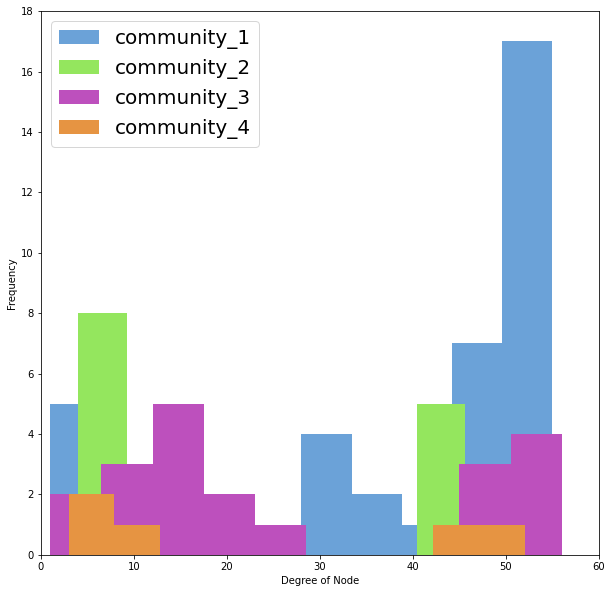

In [46]:
plt.rcParams.update({'figure.figsize': (10,10)})
fig, ax = plt.subplots()
plt.hist(hist_com_degree(1),color=community_color_all[0],label='community_1')
plt.hist(hist_com_degree(2),color=community_color_all[1],label='community_2')
plt.hist(hist_com_degree(3),color=community_color_all[2],label='community_3')
plt.hist(hist_com_degree(4),color=community_color_all[3],label='community_4')
plt.xlabel("Degree of Node")
plt.ylabel("Frequency")
plt.xlim(0,60)
plt.ylim(0,18)
plt.legend(prop={'size': 20})